#  Spam classifier

We are planning to develop a simple email spam classifier with python and scikit-learn

 First, let's import necessory library files

In [1]:
import numpy as np
import pandas as pd
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# First, let's fetch the data

We are fetching the data from http://spamassassin.apache.org/old/publiccorpus/ site. We are downloading both spam and ham emails data.

In [27]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("c:", os.sep, "Users", "JITHIN", "Desktop", "DSA", "dataset")
print(SPAM_PATH)

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

c:\Users\JITHIN\Desktop\DSA\dataset


In [28]:
fetch_spam_data()

Next, let's load all the emails:

In [29]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [30]:
len(ham_filenames)

2500

In [31]:
len(spam_filenames)

500

We can use Python's email module to parse these emails (this handles headers, encoding, etc):

In [32]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [33]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [34]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [35]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [36]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [38]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [39]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [40]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [41]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy),and the subject line "Life Insurance - Why Pay More?" 

Let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text.The following function first drops the head section, then converts all anchor tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities :

In [44]:
# importing regular expression module
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [50]:
html_spam_emails = [email for email in spam_emails
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[0]
print(sample_html_spam.get_content().strip()[:1000], "...")

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have To?
<CENTER><FONT color=#ff0000 face="Copp

And this is the resulting plain text:

In [51]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


Save up to 70% on Life Insurance.
Why Spend More Than You Have To?
Life Quote Savings
    Ensuring your
      family's financial security is very important. Life Quote Savings makes
      buying life insurance simple and affordable. We Provide FREE Access to The
      Very Best Companies and The Lowest Rates.
          Life Quote Savings is FAST, EASY and
            SAVES you money! Let us help you get started with the best values in
            the country on new coverage. You can SAVE hundreds or even thousands
            of dollars by requesting a FREE quote from Lifequote Savings. Our
            service will take you less than 5 minutes to complete. Shop and
            compare. SAVE up to 70% on all types of Life insurance!
             HYPERLINK Click Here For Your
            Free Quote!
          Protecting your family is the best investment you'll ever
          make!
      If you are in receipt of this email
      in error and/or wish to be removed from our list,  HYPERLI

Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [52]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [53]:
print(email_to_text(sample_html_spam)[:100], "...")


Save up to 70% on Life Insurance.
Why Spend More Than You Have To?
Life Quote Savings
    Ensuring  ...


Now lets do stemming.Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

For this to work, we need to install the Natural Language Toolkit (NLTK).

In [54]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None


Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this we use urlextract library. 

In [56]:
%pip install -q -U urlextract

Note: you may need to restart the kernel to use updated packages.


In [57]:
try:
    import urlextract 
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We put all this together into a transformer that we will use to convert emails to word counters. We split sentences into words using Python's split() method, which uses whitespaces for word boundaries. 

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [59]:
X_few = spam_emails[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'save': 8, 'you': 8, 'to': 6, 'life': 6, 'and': 6, 'quot': 5, 'the': 5, 'insur': 4, 'in': 4, 'number': 3, 'on': 3, 'your': 3, 'is': 3, 'free': 3, 'best': 3, 'of': 3, 'up': 2, 'than': 2, 'famili': 2, 'veri': 2, 'make': 2, 'or': 2, 'from': 2, 'our': 2, 'type': 2, 'hyperlink': 2, 'click': 2, 'here': 2, 'for': 2, 'if': 2, 'thi': 2, 'email': 2, 'remov': 2, 'pleas': 2, 'whi': 1, 'spend': 1, 'more': 1, 'have': 1, 'ensur': 1, 's': 1, 'financi': 1, 'secur': 1, 'import': 1, 'buy': 1, 'simpl': 1, 'afford': 1, 'we': 1, 'provid': 1, 'access': 1, 'compani': 1, 'lowest': 1, 'rate': 1, 'fast': 1, 'easi': 1, 'money': 1, 'let': 1, 'us': 1, 'help': 1, 'get': 1, 'start': 1, 'with': 1, 'valu': 1, 'countri': 1, 'new': 1, 'coverag': 1, 'can': 1, 'hundr': 1, 'even': 1, 'thousand': 1, 'dollar': 1, 'by': 1, 'request': 1, 'a': 1, 'lifequot': 1, 'servic': 1, 'will': 1, 'take': 1, 'less': 1, 'minut': 1, 'complet': 1, 'shop': 1, 'compar': 1, 'all': 1, 'protect': 1, 'invest': 1, 'll': 1, 'ever': 1, '

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose fit() method will build the vocabulary (an ordered list of the most common words) and whose transform() method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [60]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
             for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [87]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 24 stored elements in Compressed Sparse Row format>

In [88]:
X_few_vectors.toarray()

array([[126,   3,   5,   0,   8,   6,   8,   6,   6,   4,   5],
       [ 62,   8,   4,   7,   2,   2,   0,   0,   0,   1,   0],
       [ 46,   8,   4,   6,   2,   2,   0,   0,   0,   1,   0]],
      dtype=int32)

 the 62 in the second row, first column, means that the second email contains 62 words that are not part of the vocabulary. The 8 next to it means that the first word in the vocabulary is present 8 times in this email. The 4 next to it means that the second word is present 4 times, and so on. We can look at the vocabulary to know which words we are talking about.

In [69]:
wc = vocab_transformer.vocabulary_
wc

{'number': 1,
 'the': 2,
 'url': 3,
 'you': 4,
 'to': 5,
 'save': 6,
 'life': 7,
 'and': 8,
 'in': 9,
 'quot': 10}

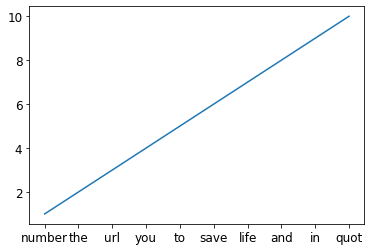

In [84]:
plt.plot(list(wc.keys()), list(wc.values()))

Now Let's transform the whole dataset

In [89]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

In [90]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_test_transformed = preprocess_pipeline.transform(X_test)

Now the test and train data is ready. Let's check for best model for prediction

First we can go with LogisticRegression

In [96]:
from sklearn.linear_model import LogisticRegression
logit_model=LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
logit_model.fit(X_train_transformed,y_train)
y_pred=logit_model.predict(X_test_transformed)


In [98]:
from sklearn.metrics import precision_score, recall_score
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.88%
Recall: 97.89%


Lets check with KNN model

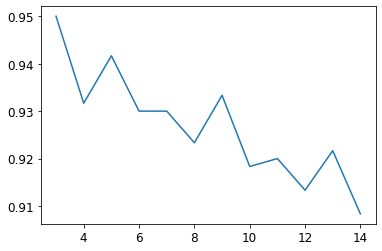

In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#to find optimal k value
acc_values=[]
for k in np.arange(3,15):
    classifier=KNeighborsClassifier(n_neighbors=k,metric='minkowski')
    classifier.fit(X_train_transformed,y_train)
    y_pred=classifier.predict(X_test_transformed)
    acc=accuracy_score(y_pred,y_test)
    acc_values.append(acc)
plt.plot(np.arange(3,15),acc_values)
plt.show()

From the above plot it is clear that 3 is giving highest values.I Am choosing 3 as optimal value for K

In [101]:
classifier=KNeighborsClassifier(n_neighbors=3,metric='minkowski')
classifier.fit(X_train_transformed,y_train)
y_pred=classifier.predict(X_test_transformed)

In [102]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 90.12%
Recall: 76.84%


SVM Model

In [103]:
from sklearn.svm import SVC
svm_linear=SVC(kernel='rbf')
svm_linear.fit(X_train_transformed,y_train)
y_pred=svm_linear.predict(X_test_transformed)

In [104]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 100.00%
Recall: 28.42%


Random Forest Classifier

In [105]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train_transformed,y_train)
y_pred=rf.predict(X_test_transformed)

In [106]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 100.00%
Recall: 91.58%


Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train_transformed,y_train)
y_pred=dt_model.predict(X_test_transformed)

In [108]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 88.00%
Recall: 92.63%


As choosing the Precision and recall metric valuesas our defining metric to models it is clare that regression classifier is best suited model for our data set

Now lets fine tune our model

In [117]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=3)
logreg_cv.fit(X_train_transformed,y_train)



C:\Users\JITHIN\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JITHIN\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JITHIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\JITHIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\JITHIN\anaconda3\lib\site-packages\sklearn\model_selecti

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
accuracy : 0.9858333333333333


C:\Users\JITHIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [119]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.9870833333333333


So we got that hyper tuned parameters and can apply them to the model

In [123]:
from sklearn.linear_model import LogisticRegression
logit_model=LogisticRegression(C=1, penalty="l2", solver="lbfgs", max_iter=1000, random_state=42)
logit_model.fit(X_train_transformed,y_train)
y_pred=logit_model.predict(X_test_transformed)


In [124]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.88%
Recall: 97.89%
